# Glow

## 0. Environment

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.distributions import transforms

## 1. Image Manipulation

In [3]:
def img2tensor(im_array,alpha=0.05,permute=True,batch_dim=True):
    """
    @param im_array: np.uint8 array-representation of an image of shape (h,w,c)
    @param alpha: scaling factor to avoid boundary effects
    @param permute: bring channel dimension to the fron of the image
    @param batch_dim: add a batch dimension to the front of the image
    
    @return: torch.float32 tensor of the image on an unbounded domain
             achieved by passing bounded image through a logit (sigmoid^-1 function)
    """
    sigmoid = transforms.SigmoidTransform()                          #initialize sigmoid transformer
    noise   = np.random.uniform(size=im_array.shape)                 #random noise in [0,1)
    im_jittered = torch.tensor(im_array + noise,dtype=torch.float32) #jittered images in [0,256), convert to tensor
    im_norm = alpha+(1-alpha)*im_jittered/256                        #normalized image in (0,1)
    im_tensor = sigmoid.inv(im_norm)                                 #convert to unbounded numbers for modelling
    if permute:
        im_tensor = im_tensor.permute(2,0,1)                         #bring channel dim to front
    if batch_dim:
        im_tensor = im_tensor.unsqueeze(0)                           #add batch dim
    return im_tensor

In [4]:
def tensor2img(im_tensor,alpha=0.05,was_permuted=True,has_batch_dim=True):
    """
    @param im_tensor: torch.float32 tensor of the image on an unbounded domain
    @param alpha: scaling factor used to generate tensor
    @param was_permuted: if True, channel dimension precedes spatial ones
    @param has_batch_dim: if True, first dimension is a batch one
    
    @return: the image as a np.uint8 array
             that is first detached from the computational graph and converted
             to a cpu tensor
    """
    sigmoid = transforms.SigmoidTransform()                 #initialize transformer
    if has_batch_dim:
        im_tensor = im_tensor.squeeze(0)                    #remove batch dim
    if was_permuted:
        im_tensor = im_tensor.permute(1,2,0)                #bring batch dim to back
    im_norm = sigmoid(im_tensor)
    im_jittered = 256*(im_norm - alpha)/(1-alpha)
    im_array = (im_jittered.detach().cpu().numpy()).astype(np.uint8)
    return im_array

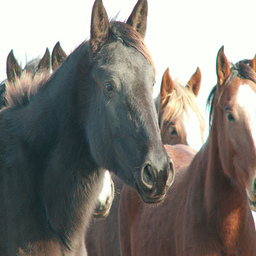

In [5]:
im = Image.open('datasets/horse2zebra/train/A/n02381460_1001.jpg')
im

In [6]:
im_array = np.array(im)
im_tensor = img2tensor(im_array)
im_array_rec = tensor2img(im_tensor)

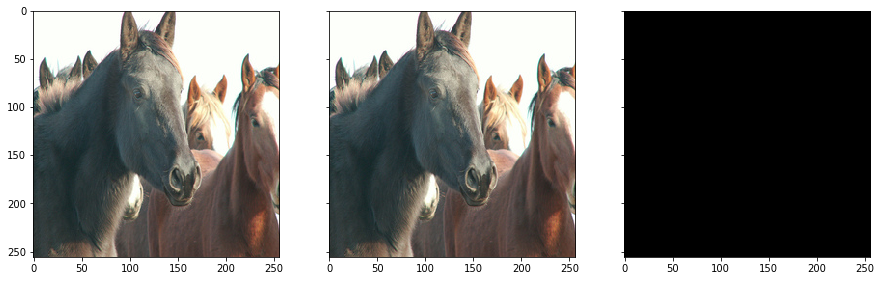

In [7]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
ax1.imshow(im_array)
ax2.imshow(im_array_rec)
ax3.imshow(im_array_rec-im_array)
plt.show()

**Summary** The function `img2tensor` allow us to convert an image that is a discrete object to one that is represented as a real-valued vector. We then use that to model the distribution. Our network output is also real-valued. We then convert that back to a natural image for vieweing using `tensor2img`. This procedure is the same as the one described in *RealNVP.*

## 2. Glow Model

Glow Helpers

In [5]:
def split_half(x):
    """
    Split along channel dimension
    """
    s = x.shape[1] // 2
    return x[:, :s, ...], x[:, s:, ...]

def _padding(k, s):
    return ((k - 1) * s + 1) // 2

def _conv(in_dim, out_dim, kernel_size, zero=False):
    """
    Returns an intialized torch.nn.Conv2d module layer
    """
    conv = nn.Conv2d(in_dim,
                     out_dim,
                     kernel_size=kernel_size,
                     padding=_padding(kernel_size, 1))
    if zero:
        nn.init.constant_(conv.weight, 0.)
        nn.init.constant_(conv.bias, 0.)
    return conv

Glow Transforms. No parameters stored here

In [6]:
class Squeeze(transforms.Transform):
    """
    Implements the invertible squeeze operation, dividing
    the spatial dimensions in half and converting them
    to channel dimensions
    """
    bijective = True
    event_dim = 3
    def __init__(self, factor):
        super(Squeeze, self).__init__()
        assert factor > 1 and isinstance(factor, int)
        self._factor = factor

    def _call(self, input):
        factor = self._factor
        size = input.size()
        B = size[0]
        C = size[1]
        H = size[2]
        W = size[3]
        assert H % factor == 0 and W % factor == 0, "{}".format((H, W))
        x = input.view(B, C, H // factor, factor, W // factor, factor)
        x = x.permute(0, 1, 3, 5, 2, 4).contiguous()
        x = x.view(B, C * factor * factor, H // factor, W // factor)
        return x

    def _inverse(self, input):
        factor = self._factor
        factor2 = factor ** 2
        size = input.size()
        B = size[0]
        C = size[1]
        H = size[2]
        W = size[3]
        assert C % (factor2) == 0, "{}".format(C)
        x = input.view(B, C // factor2, factor, factor, H, W)
        x = x.permute(0, 1, 4, 2, 5, 3).contiguous()
        x = x.view(B, C // (factor2), H * factor, W * factor)
        return x

    def log_abs_det_jacobian(self, x, y):
        return 0

class InvertibleConv1x1(transforms.Transform):
    """
    Implements the invertible 1x1 convolution
    as a transform, given the nn.conv2d module
    with weights already stored
    """
    bijective = True
    event_dim = 3
    def __init__(self, module):
        super(InvertibleConv1x1, self).__init__()
        self.module = module

    def _call(self, x):
        W = self.module.forward_kernel()
        return F.conv2d(x, W)

    def _inverse(self, x):
        W = self.module.inverse_kernel()
        return F.conv2d(x, W)

    def log_abs_det_jacobian(self, x, y):
        ndims = np.prod(x.shape[2], x.shape[3])
        return ndims * torch.log(torch.abs(torch.det(self.module.W)))
    
class ChannelCoupling(transforms.Transform):
    """
    Implements Channel Coupling as introduced in RealNVP. 
    Requires a torch.nn module to be passed as a paramters
    """
    bijective = True
    event_dim = 3
    def __init__(self, network):
        super(ChannelCoupling, self).__init__()
        self._nn = network

    def _call(self, x):
        x1, x2 = split_half(x)
        offset, scale = split_half(self._nn(x1))
        scale = torch.sigmoid(scale + 2.)
        y2 = x2 * scale + offset
        y = torch.cat([x1, y2], dim=1)
        return y

    def _inverse(self, x):
        x1, x2 = split_half(x)
        offset, scale = split_half(self._nn(x1))
        scale = torch.sigmoid(scale + 2.)
        y2 = (x2 - offset) / scale
        y = torch.cat([x1, y2], dim=1)
        return y

    def log_abs_det_jacobian(self, x, y):
        x1, x2 = split_half(x)
        _, scale = split_half(self._nn(x1))
        return torch.sum(torch.log(scale), dim=[1, 2, 3])
    
def TanhTransform():
    return transforms.ComposeTransform(
            [transforms.AffineTransform(loc=0., scale=2.),
             transforms.SigmoidTransform(),
             transforms.AffineTransform(loc=-1., scale=2.)])

Glow Invertible 1x1 Conv torch.nn module

In [7]:
class InvertibleConv1x1Matrix(nn.Module):
    def __init__(self, c):
        super(InvertibleConv1x1Matrix, self).__init__()
        self._c = c
        self.w_init = torch.Tensor(np.random.randn(self._c, self._c)).qr()[0]
        # w_init = np.linalg.qr(
        #     np.random.randn(self._c, self._c))[0].astype(np.float32)
        self.weight = nn.Parameter(self.w_init)

    def forward_kernel(self):
        return self.weight.view((self._c, self._c, 1, 1))

    def inverse_kernel(self):
        return self.weight.inverse().view((self._c, self._c, 1, 1))

Main Glow module

In [8]:
class Glow(nn.Module):
    def __init__(self, n, c, h, squeeze):
        """
        n = number of steps of flow
        c = number of input channels
        h = number of filters in conv layers
        """
        super(Glow, self).__init__()
        self._n_couple = 0
        self._n_conv1x1 = 0
        self._n, self._c, self._h = n, c, h

        t = []
        ####################################################
        #t.append(TanhTransform().inv)
        if squeeze > 1:
            t.append(Squeeze(squeeze))
            self._c = self._c * (squeeze ** 2)
        for _ in range(self._n):
            t.extend([
                InvertibleConv1x1(self._conv1x1_network()),
                ChannelCoupling(self._coupling_network())
            ])
        t.append(InvertibleConv1x1(self._conv1x1_network()))
        if squeeze > 1:
            t.append(Squeeze(squeeze).inv)
            self._c = self._c // (squeeze ** 2)
        #t.append(TanhTransform())
        ####################################################
        self.transform = transforms.ComposeTransform(t)

    def _conv1x1_network(self):
        module = InvertibleConv1x1Matrix(self._c)
        self.add_module("conv1x1_{}".format(self._n_conv1x1), module)
        self._n_conv1x1 += 1
        return module
    
    def _coupling_network(self):
        c, h = self._c, self._h
        module = nn.Sequential(
            _conv(c//2, h, kernel_size=7),
            nn.InstanceNorm2d(h),
            nn.ReLU(inplace=False),
            _conv(h, h, kernel_size=3),
            nn.InstanceNorm2d(h),
            nn.ReLU(inplace=False),
            _conv(h, c, kernel_size=7, zero=True),
        )
        self.add_module("couple_{}".format(self._n_couple), module)
        self._n_couple += 1
        return module

**Initialize Model**

In [12]:
generator = Glow(32, 3, 16, squeeze=4)

**Inputs**

In [13]:
im = Image.open('datasets/horse2zebra/train/A/n02381460_1001.jpg')
im_array = np.array(im)
im_tensor = img2tensor(im_array)

noise = torch.randn((1,3,256,256))*2

**Test Forward Pass Invertibility**

In [14]:
x     = [noise,im_tensor]
fx    = [generator.transform(_) for _ in x]
x_rec = [generator.transform.inv(_) for _ in fx]

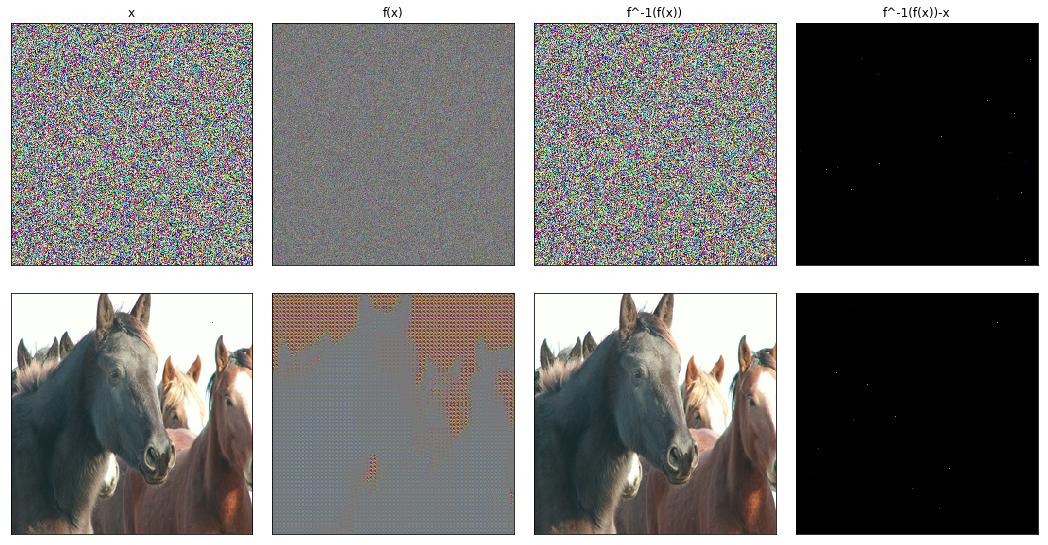

In [15]:
fig,((ax01,ax02,ax03,ax04),(ax11,ax12,ax13,ax14)) = plt.subplots(2,4,figsize=(15,8),sharex=True,sharey=True)
#noise input
ax01.imshow(tensor2img(x[0]))
ax02.imshow(tensor2img(fx[0]))
ax03.imshow(tensor2img(x_rec[0]))
ax04.imshow(tensor2img(x_rec[0])-tensor2img(x[0]))
#horse input
ax11.imshow(tensor2img(x[1]))
ax12.imshow(tensor2img(fx[1]))
ax13.imshow(tensor2img(x_rec[1]))
ax14.imshow(tensor2img(x_rec[1])-tensor2img(x[1]))
#visual plot elements
ax01.set_title('x')
ax02.set_title('f(x)')
ax03.set_title('f^-1(f(x))')
ax04.set_title('f^-1(f(x))-x')
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

**Test Backward Pass Invertibility**

In [16]:
y     = [noise,im_tensor]
gy    = [generator.transform.inv(_) for _ in y]
y_rec = [generator.transform(_) for _ in gy]

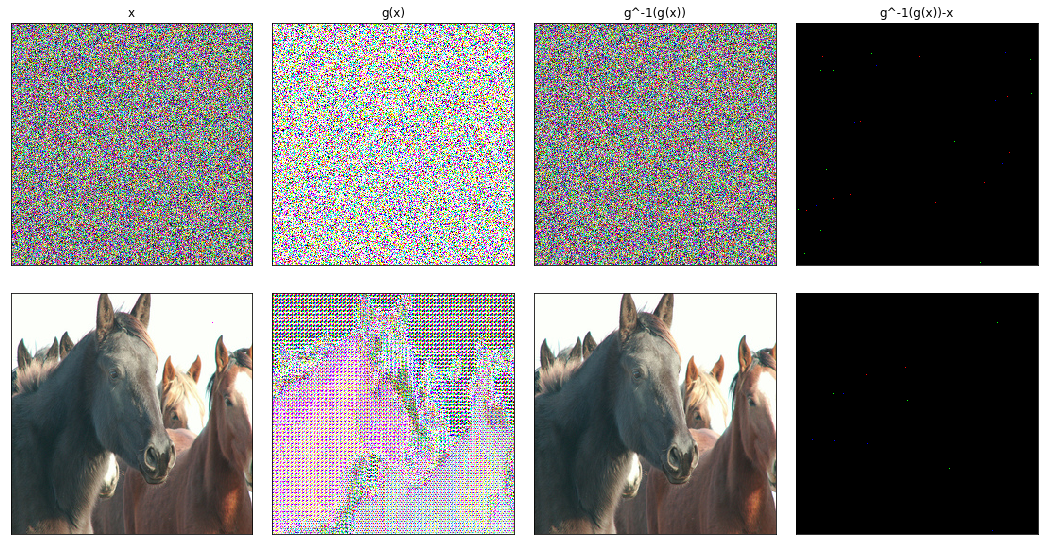

In [17]:
fig,((ax01,ax02,ax03,ax04),(ax11,ax12,ax13,ax14)) = plt.subplots(2,4,figsize=(15,8),sharex=True,sharey=True)
#noise input
ax01.imshow(tensor2img(y[0]))
ax02.imshow(tensor2img(gy[0]))
ax03.imshow(tensor2img(y_rec[0]))
ax04.imshow(tensor2img(y_rec[0])-tensor2img(y[0]))
#horse input
ax11.imshow(tensor2img(y[1]))
ax12.imshow(tensor2img(gy[1]))
ax13.imshow(tensor2img(y_rec[1]))
ax14.imshow(tensor2img(y_rec[1])-tensor2img(y[1]))
#visual plot elements
ax01.set_title('x')
ax02.set_title('g(x)')
ax03.set_title('g^-1(g(x))')
ax04.set_title('g^-1(g(x))-x')
plt.tight_layout()
plt.xticks([])
plt.yticks([])
plt.show()

## 3. Map 1 image -> 1 image, using MSE Loss (overfit)

Device

In [48]:
device = torch.device('cuda')

Input and Output

In [54]:
im = [Image.open('datasets/horse2zebra/train/A/n02381460_1001.jpg'),
      Image.open('datasets/horse2zebra/train/B/n02391049_10007.jpg')]
im_array = [np.array(_) for _ in im]
im_tensor = [img2tensor(_) for _ in im_array]

x = im_tensor[0].to(device)
y = im_tensor[1].to(device)

Generator

In [50]:
generator = Glow(32, 3, 16, squeeze=4).to(device)

Loss

In [58]:
mse_loss = torch.nn.MSELoss()

Optimizer

In [52]:
optimizer_G = torch.optim.Adam(generator.parameters(),
                               lr=0.0002, betas=(0.5, 0.999),
                               weight_decay=1e-3)

Initial Mapping

In [9]:
def draw_image_row(tensors,labels):
    assert(len(tensors)==len(labels))
    n = len(tensors)
    fig,ax = plt.subplots(1,n,figsize=(4*n,4),sharex=True,sharey=True)
    for a,t,l in zip(ax,tensors,labels):
        a.imshow(tensor2img(t))
        a.set_title(l)
    plt.tight_layout()
    plt.xticks([])
    plt.yticks([])
    plt.show()

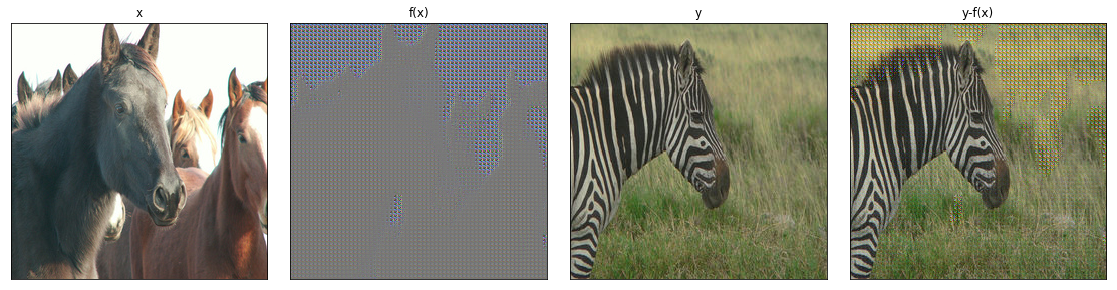

In [55]:
fx = generator.transform(x)
draw_image_row([x,fx,y,y-fx],['x','f(x)','y','y-f(x)'])

Ideal Output

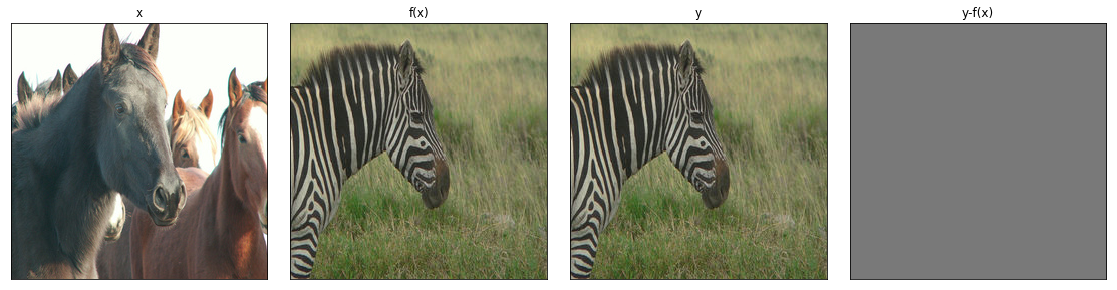

In [55]:
fx = y
draw_image_row([x,fx,y,y-fx],['x','f(x)','y','y-f(x)'])

Training Loop

In [61]:
cur_epoch = 0

In [111]:
for i in range(5):
    optimizer_G.zero_grad()
    fx = generator.transform(x)
    loss = mse_loss(fx,y)
    loss.backward()
    optimizer_G.step()
    cur_epoch += 1
    print("Epoch {}: loss = {}".format(cur_epoch,loss))

Epoch 481: loss = 0.03289364278316498
Epoch 482: loss = 0.03289257735013962
Epoch 483: loss = 0.03289151191711426
Epoch 484: loss = 0.0328904427587986
Epoch 485: loss = 0.03288937732577324


In [106]:
for param_group in optimizer_G.param_groups:
        param_group['lr'] = 0.000001 #param_group['lr']/2

Test Model

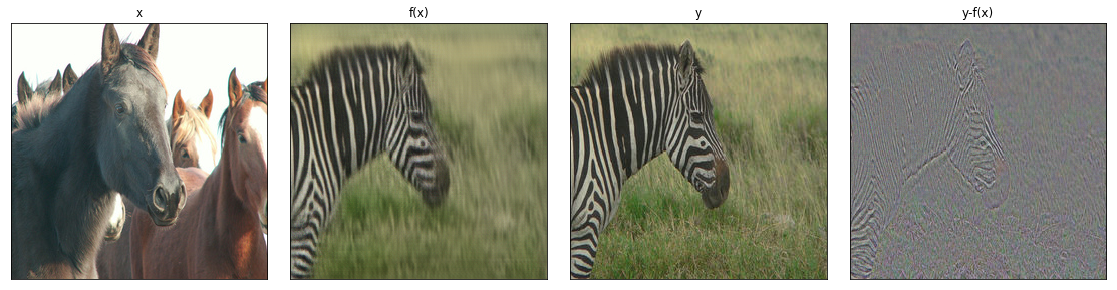

In [112]:
#Input during training
fx = generator.transform(x)
draw_image_row([x,fx,y,y-fx],['x','f(x)','y','y-f(x)'])

In [113]:
#Error in pixel space
t = transforms.SigmoidTransform()
((t(fx)-t(y))**2).mean()

tensor(0.0016, device='cuda:0', grad_fn=<MeanBackward1>)

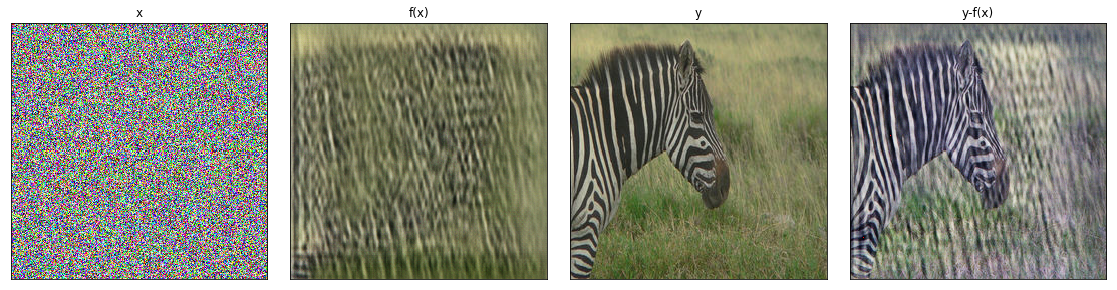

In [114]:
#Noise input
noise = (torch.randn((1,3,256,256))*2).to(device)
fx = generator.transform(noise)
draw_image_row([noise,fx,y,y-fx],['x','f(x)','y','y-f(x)'])

## 4. Map 1 Image -> Domain

In [47]:
device = torch.device('cuda')
im = Image.open('datasets/horse2zebra/train/A/n02381460_1001.jpg')
im_array = np.array(im)
im_tensor = img2tensor(im_array)
x = im_tensor.to(device)

In [48]:
criterion_GAN = torch.nn.MSELoss()

In [49]:
generator = Glow(32, 3, 16, squeeze=4).to(device)

In [50]:
from models import Discriminator
from utils import weights_init_normal
discriminator = Discriminator(3).to(device)
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [51]:
t = TanhTransform()
s = transforms.SigmoidTransform()

In [52]:
optimizer_G = torch.optim.Adam(generator.parameters(),lr=0.00002, betas=(0.5, 0.999),weight_decay=1e-3)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.00002, betas=(0.5, 0.999),weight_decay=1e-3)

In [53]:
import torchvision.transforms as tvf
from torch.utils.data import DataLoader
from datasets import ImageDataset

In [54]:
transforms_ = [tvf.Resize(int(256*1.12), Image.BICUBIC),
               tvf.RandomCrop(256)]
dataloader = DataLoader(ImageDataset('datasets/horse2zebra/', transforms_=transforms_, unaligned=True),
                        batch_size=1, shuffle=True, num_workers=4)

In [55]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if device == torch.device('cuda') else torch.Tensor
input_A = Tensor(1, 3, 256, 256)
input_B = Tensor(1, 3, 256, 256)
target_real = Variable(Tensor(1).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(1).fill_(0.0), requires_grad=False)

In [56]:
cur_epoch = 0

In [61]:
for i, batch in enumerate(dataloader):
    #Get Data
    A = batch['A'] #ignore A for now
    B = batch['B']
    
    #Copy to fixed memory location
    real_A = Variable(input_A.copy_(A))
    real_B = Variable(input_B.copy_(B))
    
    #Generator
    fake_B = None
    if True:
        optimizer_G.zero_grad()
        fake_B = generator.transform.inv(real_A)
        pred_fake = discriminator(t(fake_B))
        loss_G = criterion_GAN(pred_fake, target_real)
        loss_G.backward()
        optimizer_G.step()
    else:
        fake_B = generator.transform(real_A)
    
    #Discriminator for B
    if True:
        optimizer_D.zero_grad()

        # Real loss
        pred_real = discriminator(t(real_B))
        loss_D_real = criterion_GAN(pred_real, target_real)

        # Fake loss
        #fake_B = fake_B_buffer.push_and_pop(fake_B)
        pred_fake = discriminator(t(fake_B.detach()))
        loss_D_fake = criterion_GAN(pred_fake, target_fake)

        # Total loss
        loss_D = (loss_D_real + loss_D_fake)*0.5
        loss_D.backward()
        
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        optimizer_D.step()    
     
    #Log
    cur_epoch += 1
    print("Iteration {}: loss_G = {:.5f}, loss_D = {:.5f}".format(cur_epoch,loss_G,loss_D))
    
    if i > 15: 
        break

Iteration 35: loss_G = 0.58393, loss_D = 0.07209
Iteration 36: loss_G = 0.50855, loss_D = 0.07437
Iteration 37: loss_G = 0.42026, loss_D = 0.10571
Iteration 38: loss_G = 0.97018, loss_D = 0.09786
Iteration 39: loss_G = 1.28851, loss_D = 0.03155
Iteration 40: loss_G = 1.12745, loss_D = 0.02316
Iteration 41: loss_G = 0.87637, loss_D = 0.00345
Iteration 42: loss_G = 1.41501, loss_D = 0.01889
Iteration 43: loss_G = 1.14141, loss_D = 0.00530
Iteration 44: loss_G = 0.63317, loss_D = 0.02252
Iteration 45: loss_G = 0.89667, loss_D = 0.03155
Iteration 46: loss_G = 1.16295, loss_D = 0.00894
Iteration 47: loss_G = 1.07311, loss_D = 0.00065
Iteration 48: loss_G = 0.68151, loss_D = 0.02215
Iteration 49: loss_G = 0.95407, loss_D = 0.04316
Iteration 50: loss_G = 1.16804, loss_D = 0.05105
Iteration 51: loss_G = 1.15232, loss_D = 0.00374


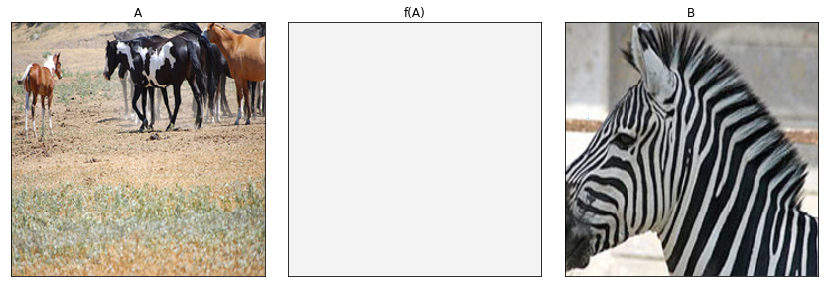

In [63]:
#Input during training
draw_image_row([A,generator.transform.inv(A.cuda()),B],['A','f(A)','B'])

## 5. Full Cycle-GAN objective

Initialize Networks

In [25]:
from models import Discriminator
from utils import weights_init_normal,LambdaLR,ReplayBuffer

import torchvision.transforms as tvf
from torch.utils.data import DataLoader
from datasets import ImageDataset

In [26]:
generator = Glow(16, 3, 32, squeeze=4)
netD_A = Discriminator(3)
netD_B = Discriminator(3)

generator.cuda()
netD_A.cuda()
netD_B.cuda()

netD_A.apply(weights_init_normal)
netD_B.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  )
)

In [27]:
criterion_GAN = torch.nn.MSELoss()
criterion_identity = torch.nn.MSELoss() #torch.nn.L1Loss()

In [28]:
optimizer_G = torch.optim.Adam(generator.parameters(),
                               lr=0.00001, betas=(0.5, 0.999),
                               weight_decay=1e-2)
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(200, 0, 100).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(200, 0, 100).step)

In [29]:
Tensor = torch.cuda.FloatTensor if True else torch.Tensor
input_A = Tensor(1, 3, 128, 128)
input_B = Tensor(1, 3, 128, 128)
target_real = Variable(Tensor(1).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(1).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [30]:
transforms_ = [tvf.Resize(int(128*1.12), Image.BICUBIC),
               tvf.RandomCrop(128),
               tvf.RandomHorizontalFlip(),
              ]
dataloader = DataLoader(ImageDataset('datasets/facades/', transforms_=transforms_, unaligned=True),
                        batch_size=1, shuffle=True, num_workers=4)

In [31]:
t = TanhTransform()
u = torch.distributions.Uniform(-0.3,0.3)

In [32]:
cur_epoch = 0

In [93]:
for i, batch in enumerate(dataloader):
    ###### Input ######################
    A = batch['A']
    B = batch['B']

    real_A = Variable(input_A.copy_(A))
    real_B = Variable(input_B.copy_(B))

    
    ###### Generators A2B and B2A ######
    optimizer_G.zero_grad()
    
    # Identity loss
    same_B = generator.transform(real_B)       # G_A2B(B) should equal B if real B is fed
    same_A = generator.transform.inv(real_A)   # G_B2A(A) should equal A if real A is fed
    loss_identity = (criterion_identity(same_B, real_B) + criterion_identity(same_A, real_A))*0.5
    
    #same_A = generator.transform(real_A)       # G_A2B(B) should equal B if real B is fed
    #same_B = generator.transform.inv(real_B)   # G_B2A(A) should equal A if real A is fed
    #loss_identity_2 = criterion_identity(same_B, real_B) + criterion_identity(same_A, real_A)    
    
    # GAN loss
    fake_B = generator.transform(real_A)
    pred_fake = netD_B(t(fake_B))
    loss_GAN_A2B = criterion_GAN(pred_fake, target_real+u.rsample().to('cuda'))

    fake_A = generator.transform.inv(real_B)
    pred_fake = netD_A(t(fake_A))
    loss_GAN_B2A = criterion_GAN(pred_fake, target_real+u.rsample().to('cuda'))
    
    loss_GAN = loss_GAN_A2B + loss_GAN_B2A
    
    #Total Loss
    loss_G = loss_GAN + 12*loss_identity #+ 0.5*loss_identity_2
    loss_G.backward()
    
    torch.nn.utils.clip_grad_value_(generator.parameters(),2)
    
    optimizer_G.step()
    
    ###### Discriminator A ######
    optimizer_D_A.zero_grad()

    # Real loss
    pred_real = netD_A(t(real_A))  #.view(target_real.shape)
    loss_D_real = criterion_GAN(pred_real, target_real+u.rsample().to('cuda'))

    # Fake loss
    fake_A = fake_A_buffer.push_and_pop(fake_A)
    pred_fake = netD_A(t(fake_A.detach()))
    loss_D_fake = criterion_GAN(pred_fake, target_fake+u.rsample().to('cuda'))

    # Total loss
    loss_D_A = (loss_D_real + loss_D_fake)*0.5
    loss_D_A.backward()

    optimizer_D_A.step()


    ###### Discriminator B ######
    optimizer_D_B.zero_grad()

    # Real loss
    pred_real = netD_B(t(real_B))
    loss_D_real = criterion_GAN(pred_real, target_real+u.rsample().to('cuda'))

    # Fake loss
    fake_B = fake_B_buffer.push_and_pop(fake_B)
    pred_fake = netD_B(t(fake_B.detach()))
    loss_D_fake = criterion_GAN(pred_fake, target_fake+u.rsample().to('cuda'))

    # Total loss
    loss_D_B = (loss_D_real + loss_D_fake)*0.5
    loss_D_B.backward()

    optimizer_D_B.step()
    
    
    ###### Log ######
    cur_epoch += 1
    print("Iteration {}: loss_G_identity = ({:.5f},{:.5f}), loss_G_GAN = {:.5f}, loss_D_A = {:.5f}, loss_D_B = {:.5f}".format(cur_epoch,loss_identity,0,loss_GAN,loss_D_A,loss_D_B))
    
    if i > 50: 
        break

Iteration 1161: loss_G_identity = (0.40111,0.00000), loss_G_GAN = 1.01556, loss_D_A = 0.02902, loss_D_B = 0.20301
Iteration 1162: loss_G_identity = (0.54396,0.00000), loss_G_GAN = 1.83574, loss_D_A = 0.09320, loss_D_B = 0.03025
Iteration 1163: loss_G_identity = (0.55288,0.00000), loss_G_GAN = 2.11793, loss_D_A = 0.01124, loss_D_B = 0.00727
Iteration 1164: loss_G_identity = (0.37161,0.00000), loss_G_GAN = 2.49896, loss_D_A = 0.13811, loss_D_B = 0.00142
Iteration 1165: loss_G_identity = (0.46522,0.00000), loss_G_GAN = 2.67141, loss_D_A = 0.07645, loss_D_B = 0.17090
Iteration 1166: loss_G_identity = (0.29166,0.00000), loss_G_GAN = 1.63978, loss_D_A = 0.15255, loss_D_B = 0.06935
Iteration 1167: loss_G_identity = (0.54777,0.00000), loss_G_GAN = 2.14770, loss_D_A = 0.04221, loss_D_B = 0.13407
Iteration 1168: loss_G_identity = (0.55347,0.00000), loss_G_GAN = 1.78316, loss_D_A = 0.18535, loss_D_B = 0.10357
Iteration 1169: loss_G_identity = (0.42444,0.00000), loss_G_GAN = 1.15406, loss_D_A = 0.

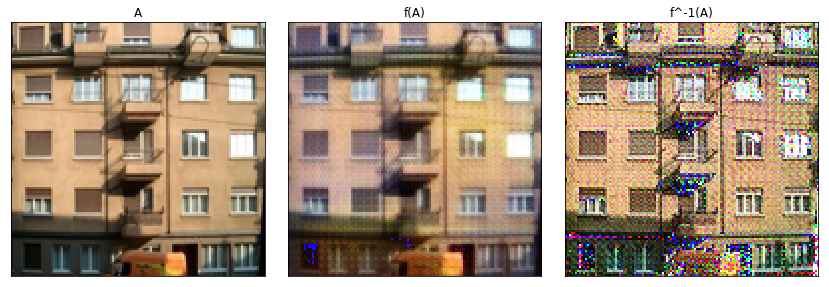

In [92]:
#Input during training
draw_image_row([A,generator.transform(A.cuda()),generator.transform.inv(A.cuda())],['A','f(A)','f^-1(A)'])

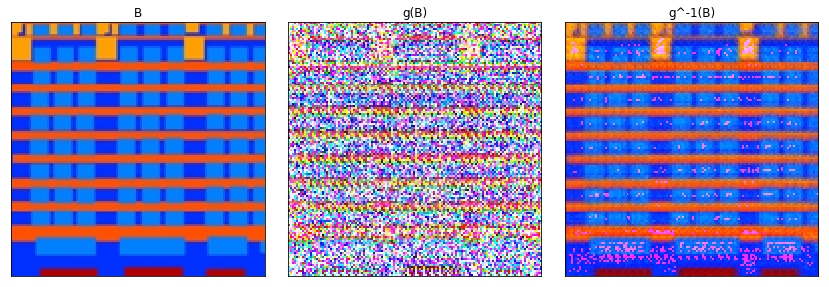

In [90]:
#Input during training
draw_image_row([B,generator.transform.inv(B.cuda()),generator.transform(B.cuda())],['B','g(B)','g^-1(B)'])

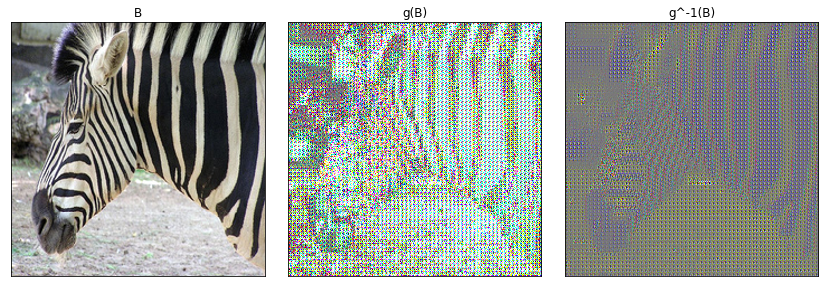

In [47]:
#Input during training
draw_image_row([B,generator.transform.inv(B.cuda()),generator.transform(B.cuda())],['B','g(B)','g^-1(B)'])

Save

In [89]:
torch.save(generator.state_dict(), 'output/generator.pth')
torch.save(netD_A.state_dict(), 'output/netD_A.pth')
torch.save(netD_B.state_dict(), 'output/netD_B.pth')

Load

In [33]:
generator.load_state_dict(torch.load('output/generator.pth')) 
netD_A.load_state_dict(torch.load('output/netD_A.pth')) 
netD_B.load_state_dict(torch.load('output/netD_B.pth')) 